In [186]:
%load_ext lab_black

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### 1. Elección del dataset

Para realizar este trabajo utilizaremos el dataset de comidas de [McDonald's](https://www.kaggle.com/datasets/mcdonalds/nutrition-facts) provisto por Kaggle.

In [187]:
# file_path = "menu.csv"
file_path = "/tf/notebooks/CEIA-analisis_de_datos/TP_final/dataset/menu.csv"

df_original = pd.read_csv(file_path)
df = df_original.copy()

### 2. Análisis exploratiorio inicial

- Visualizar las primeras filas.

In [188]:
df.head()

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10


El dataset contiene 24 columnas y la cantidad de datos es:

In [189]:
df.shape[0]

260

- Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

| Nombre                        | Tipo            | Informativa |
| :---------------------------- | :-------------: |  :--------: |
| Category                      | Categórica      | Si          |
| Item                          | Categórica      | No          |
| Serving Size                  | Numérica        | Si          |
| Calories                      | Numérica        | Si          |
| Calories from Fat             | Numérica        | Si          |
| Total Fat                     | Numérica        | Si          |
| Total Fat (% Daily Value)     | Numérica        | Si          |
| Saturated Fat                 | Numérica        | Si          |
| Saturated Fat (% Daily Value) | Numérica        | Si          |
| Trans Fat	                    | Numérica        | Si          |
| Cholesterol                   | Numérica        | Si          |
| Cholesterol (% Daily Value)   | Numérica        | Si          |
| Sodium                        | Numérica        | Si          |
| Sodium (% Daily Value)        | Numérica        | Si          |
| Carbohydrates                 | Numérica        | Si          |
| Carbohydrates (% Daily Value) | Numérica        | Si          |
| Dietary Fiber                 | Numérica        | Si          |
| Dietary Fiber (% Daily Value) | Numérica        | Si          |
| Sugars                        | Numérica        | Si          |
| Protein                       | Numérica        | Si          |
| Vitamin A (% Daily Value)     | Numérica        | Si          |
| Vitamin C (% Daily Value)     | Numérica        | Si          |
| Calcium (% Daily Value)       | Numérica        | Si          |
| Iron (% Daily Value)          | Numérica        | Si          |

  La columna *Item* asigna un nombre unico para cada fila por lo tanto esta columna no resulta de interes para el análisis. Se descarta.

  A priori, el resto de columnas, por si solas, parecen ser informativas para un problema de clasificación. Sin embargo, todas las variables que se repiten con *(% Daily Value)* presentan información duplicada ya que el valor normal y el valor % solo difieren en la escala. Incluso, debido a que los porcentajes están redondeados a números enteros se podría perder información ya que dos valores cercanos se podrían mapear al mismo porcentaje. Por esta razón se deciden eliminar las variables que cuentan con su valor normal y en porcentaje.

In [190]:
df.drop(
    columns=[
        "Item",
        "Total Fat (% Daily Value)",
        "Saturated Fat (% Daily Value)",
        "Cholesterol (% Daily Value)",
        "Sodium (% Daily Value)",
        "Carbohydrates (% Daily Value)",
        "Dietary Fiber (% Daily Value)",
    ],
    inplace=True,
)
df.head()

,Category,Serving Size,Calories,Calories from Fat,Total Fat,Saturated Fat,Trans Fat,Cholesterol,Sodium,Carbohydrates,Dietary Fiber,Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,4.8 oz (136 g),300,120,13.0,5.0,0.0,260,750,31,4,3,17,10,0,25,15
1,Breakfast,4.8 oz (135 g),250,70,8.0,3.0,0.0,25,770,30,4,3,18,6,0,25,8
2,Breakfast,3.9 oz (111 g),370,200,23.0,8.0,0.0,45,780,29,4,2,14,8,0,25,10
3,Breakfast,5.7 oz (161 g),450,250,28.0,10.0,0.0,285,860,30,4,2,21,15,0,30,15
4,Breakfast,5.7 oz (161 g),400,210,23.0,8.0,0.0,50,880,30,4,2,21,6,0,25,10


- Realizar un resumen de 5 números.
  
  Utilizamos la función *describe* de pandas que nos permite obtener un resumen de los datos por columna.

In [191]:
df.drop(columns=["Category", "Serving Size"]).describe()

,Calories,Calories from Fat,Total Fat,Saturated Fat,Trans Fat,Cholesterol,Sodium,Carbohydrates,Dietary Fiber,Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,368.269231,127.096154,14.165385,6.007692,0.203846,54.942308,495.750000,47.346154,1.630769,29.423077,13.338462,13.426923,8.534615,20.973077,7.734615
std,240.269886,127.875914,14.205998,5.321873,0.429133,87.269257,577.026323,28.252232,1.567717,28.679797,11.426146,24.366381,26.345542,17.019953,8.723263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,210.000000,20.000000,2.375000,1.000000,0.000000,5.000000,107.500000,30.000000,0.000000,5.750000,4.000000,2.000000,0.000000,6.000000,0.000000
50%,340.000000,100.000000,11.000000,5.000000,0.000000,35.000000,190.000000,44.000000,1.000000,17.500000,12.000000,8.000000,0.000000,20.000000,4.000000
75%,500.000000,200.000000,22.250000,10.000000,0.000000,65.000000,865.000000,60.000000,3.000000,48.000000,19.000000,15.000000,4.000000,30.000000,15.000000
max,1880.000000,1060.000000,118.000000,20.000000,2.500000,575.000000,3600.000000,141.000000,7.000000,128.000000,87.000000,170.000000,240.000000,70.000000,40.000000


- Identificar las variables de entrada y de salida del problema.

En este caso se elije *Calories* como variable de salida por lo tanto será un problema de regresión. Las demas features se pueden usar como variables entrada. Aunque quizá se deba eliminar la columna *Calories from Fat* ya que si no se conoce el valor de *Calories* probablemente tampoco el de *Calories from Fat*

- Variables de entrada: 
  - Realizar los siguientes análisis por tipo de variable: 
    - Numéricas: Obtener conclusiones acerca de la distribución de los datos. 
    - Categóricas: Obtener conclusiones acerca de la cardinalidad, representación de cada categoría, etc. 
    - Compuestas: ¿Pueden tratarse para utilizarse en el problema a resolver? 

#### Variables Numéricas

  Para analizar la variable *Serving Size* debemos preprocesar los datos ya que la columna contiene los valores en *onzas* y *gramos* para los alimentos solidos y en *onza líquida* para los líquidos. 

Se dividirá *Serving Size* en dos columnas una para líquidos y otra para sólidos. Se convertirán todos los valores a onzas.

Ademas se agregará una nueva columna categórica para indicar si el producto es líquido o sólido.

In [192]:
extract_number_parentheses = lambda df: df.str.extract(
    r"\((.*)\)", expand=False
).str.extract(r"(\d+)")
extract_number_float = lambda df: df.str.extract(r"(\d*\.\d+|\d+)").astype("float")
g_to_oz = lambda x: x * 0.035274
ml_to_fl_oz = lambda x: x * 0.033814

# Crear nueva columna 'Serving Size Solid' para los solidos

# Extraer valores que tienen 'g' y 'oz'
mask_g = df["Serving Size"].str.contains(r"^(?=.*g)(?!.*cookie)")
solids_g = extract_number_float(df["Serving Size"][mask_g])
serving_size_solid_1 = solids_g.astype(float)

# Convertir los valores que solo tienen 'g' a 'oz'
mask_cookie = df["Serving Size"].str.contains("cookie")
solids_cookie = extract_number_parentheses(df["Serving Size"][mask_cookie])
serving_size_solid_2 = g_to_oz(solids_cookie.astype(float))

# Reemplazar los valores en el dataset original
serving_size_solid = pd.concat([serving_size_solid_1, serving_size_solid_2])
for i, _ in serving_size_solid.iterrows():
    df.loc[df.index == i, "Serving Size Solid"] = serving_size_solid[0][i]

# Crear nueva columna 'Serving Size Liquid' para los liquidos

# Extraer valores que tienen 'fl oz' y no 'ml'
mask_fl_oz = df["Serving Size"].str.contains(r"^(?=.*fl oz)(?!.*ml)")
liquids_fl_oz = extract_number_float(df["Serving Size"][mask_fl_oz])
serving_size_liquid_1 = liquids_fl_oz.astype(float)

# Convertir los valores que contien 'ml' a 'fl oz'
mask_ml = df["Serving Size"].str.contains("ml")
liquids_ml = extract_number_parentheses(df["Serving Size"][mask_ml])
serving_size_liquid_2 = ml_to_fl_oz(liquids_ml.astype(float))

# Reemplazar los valores en el dataset original
serving_size_liquid = pd.concat([serving_size_liquid_1, serving_size_liquid_2])
for i, _ in serving_size_liquid.iterrows():
    df.loc[df.index == i, "Serving Size Liquid"] = serving_size_liquid[0][i]

# Crear una nueva columna categorica 'Solid' para diferenciar los liquidos de los solidos

df["Solid"] = (
    df["Serving Size Solid"]
    .where(df["Serving Size Solid"].isnull(), 1)
    .fillna(0)
    .astype(int)
)


# Reemplazar los valores NaN de 'Serving Size Solid' y 'Serving Size Liquid' por 0

df["Serving Size Solid"] = df["Serving Size Solid"].fillna(0)
df["Serving Size Liquid"] = df["Serving Size Liquid"].fillna(0)

# Eliminar la columna 'Serving Size'

df.drop(columns=["Serving Size"], inplace=True)

df[105:115]

,Category,Calories,Calories from Fat,Total Fat,Saturated Fat,Trans Fat,Cholesterol,Sodium,Carbohydrates,Dietary Fiber,Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Serving Size Solid,Serving Size Liquid,Solid
105,Desserts,150,50,6.0,2.5,0.0,10,135,22,1,13,2,2,0,2,6,1.164042,0.0,1
106,Desserts,45,10,1.5,1.0,0.0,5,20,7,0,6,1,2,0,4,0,1.000000,0.0,1
107,Desserts,330,80,9.0,7.0,0.0,25,170,53,1,48,8,8,0,25,8,6.300000,0.0,1
108,Desserts,340,70,8.0,5.0,0.0,30,150,60,0,43,7,10,0,25,0,6.400000,0.0,1
109,Desserts,280,60,6.0,4.0,0.0,25,85,49,0,45,6,8,4,20,0,6.300000,0.0,1
110,Beverages,140,0,0.0,0.0,0.0,0,0,39,0,39,0,0,0,0,0,0.000000,16.0,0
111,Beverages,200,0,0.0,0.0,0.0,0,5,55,0,55,0,0,0,0,0,0.000000,21.0,0
112,Beverages,280,0,0.0,0.0,0.0,0,5,76,0,76,0,0,0,0,0,0.000000,30.0,0
113,Beverages,100,0,0.0,0.0,0.0,0,0,28,0,28,0,0,0,0,0,0.000000,12.0,0
114,Beverages,0,0,0.0,0.0,0.0,0,10,0,0,0,0,0,0,0,0,0.000000,16.0,0


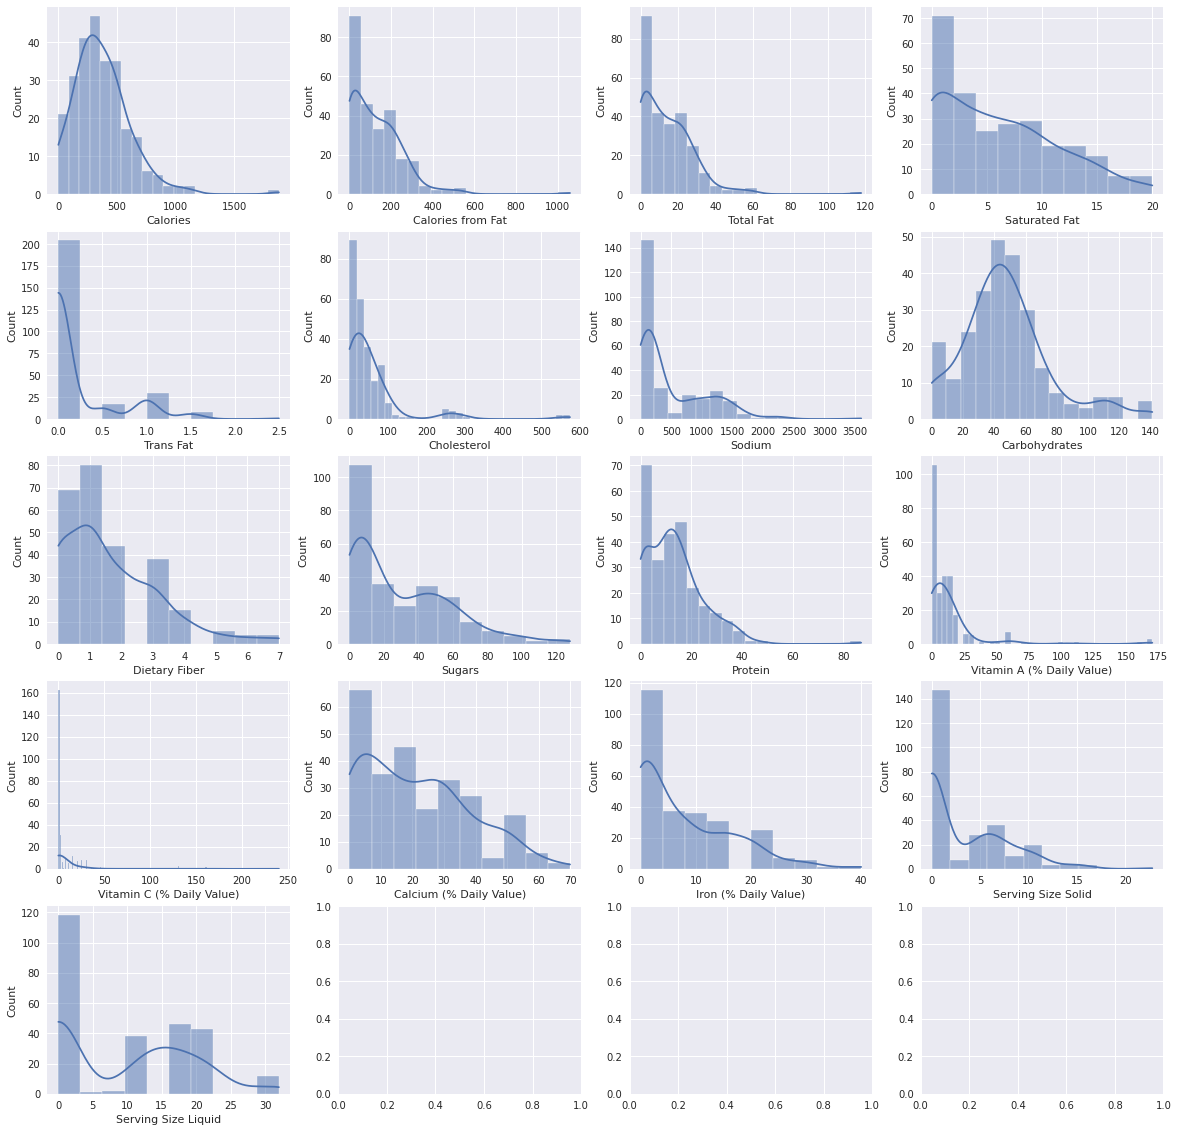

In [193]:
df_numeric = df.drop(columns=["Category", "Solid"])

f, axes = plt.subplots(5, 4, figsize=(20, 20))
for ax, feature in zip(axes.flat, df_numeric.columns):
    sns.histplot(df_numeric[feature], ax=ax, kde=True)

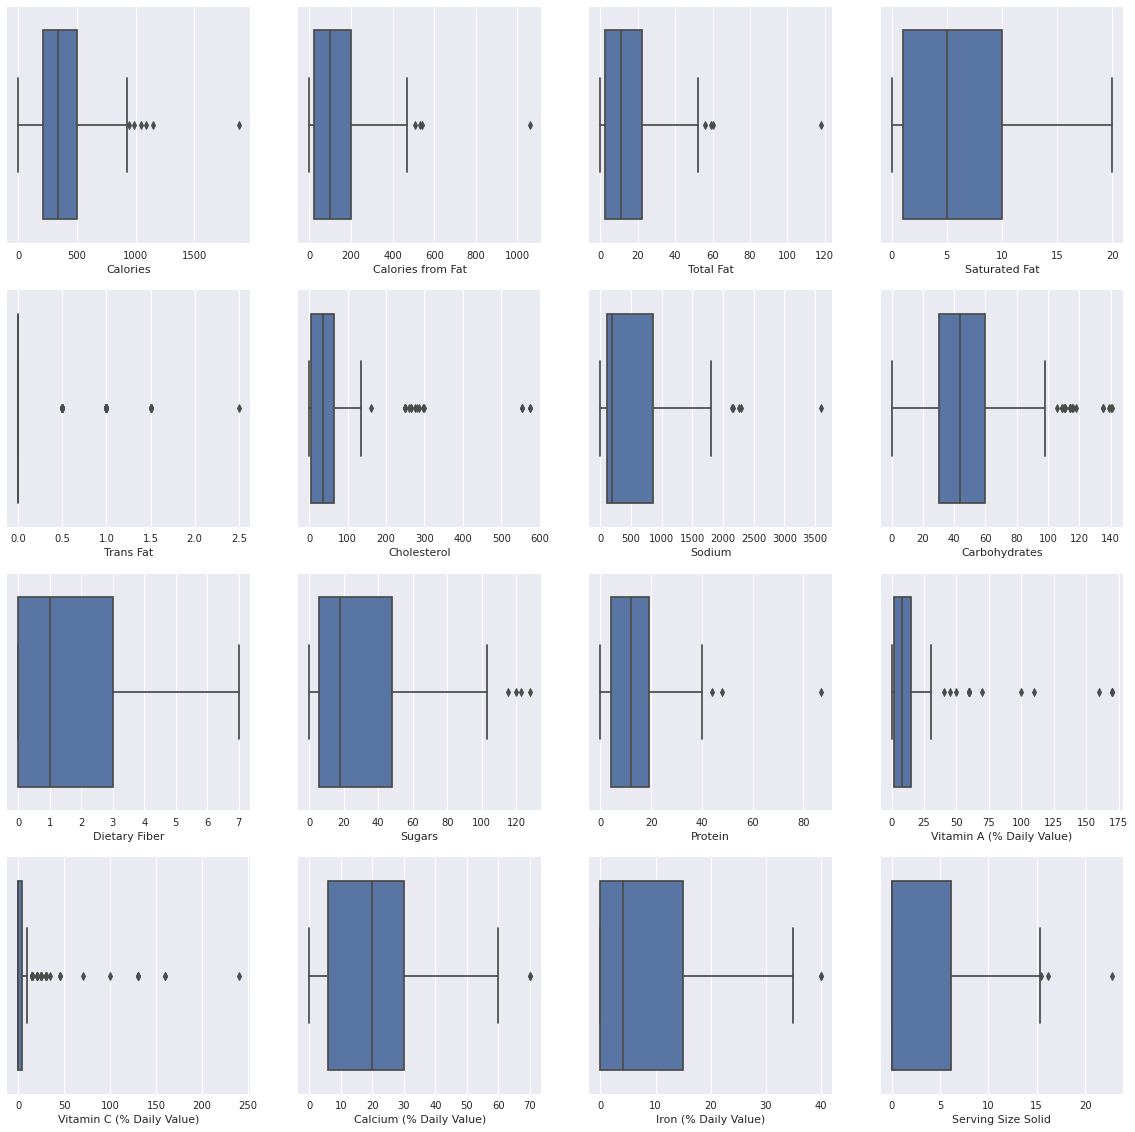

In [194]:
f, axes = plt.subplots(4, 4, figsize=(20, 20))
for ax, feature in zip(axes.flat, df_numeric.columns):
    sns.boxplot(x=df_numeric[feature], ax=ax)

### Outliers

Analizando los outliers en detenimiento llegamos a la conclusión de que no son valores ingresados erroneamente y son informativos en el problema a resolver. Por lo tanto no se los eliminará.

#### Variables Categóricas

Unicamente las columnas *Category* e *Item* son categóricas. Analizamos la cardinalidad de la primera.

In [195]:
df["Category"].value_counts()

Coffee & Tea          95
Breakfast             42
Smoothies & Shakes    28
Chicken & Fish        27
Beverages             27
Beef & Pork           15
Snacks & Sides        13
Desserts               7
Salads                 6
Name: Category, dtype: int64

Podemos ver que hay 9 clases distintas con su cardinalidad.

### Deteccion de valores nulos

In [196]:
df.isna().sum()

Category                     0
Calories                     0
Calories from Fat            0
Total Fat                    0
Saturated Fat                0
Trans Fat                    0
Cholesterol                  0
Sodium                       0
Carbohydrates                0
Dietary Fiber                0
Sugars                       0
Protein                      0
Vitamin A (% Daily Value)    0
Vitamin C (% Daily Value)    0
Calcium (% Daily Value)      0
Iron (% Daily Value)         0
Serving Size Solid           0
Serving Size Liquid          0
Solid                        0
dtype: int64

Se puede observar que nuestro dataset no contiene valores nulos

# Analisis de colinealidad

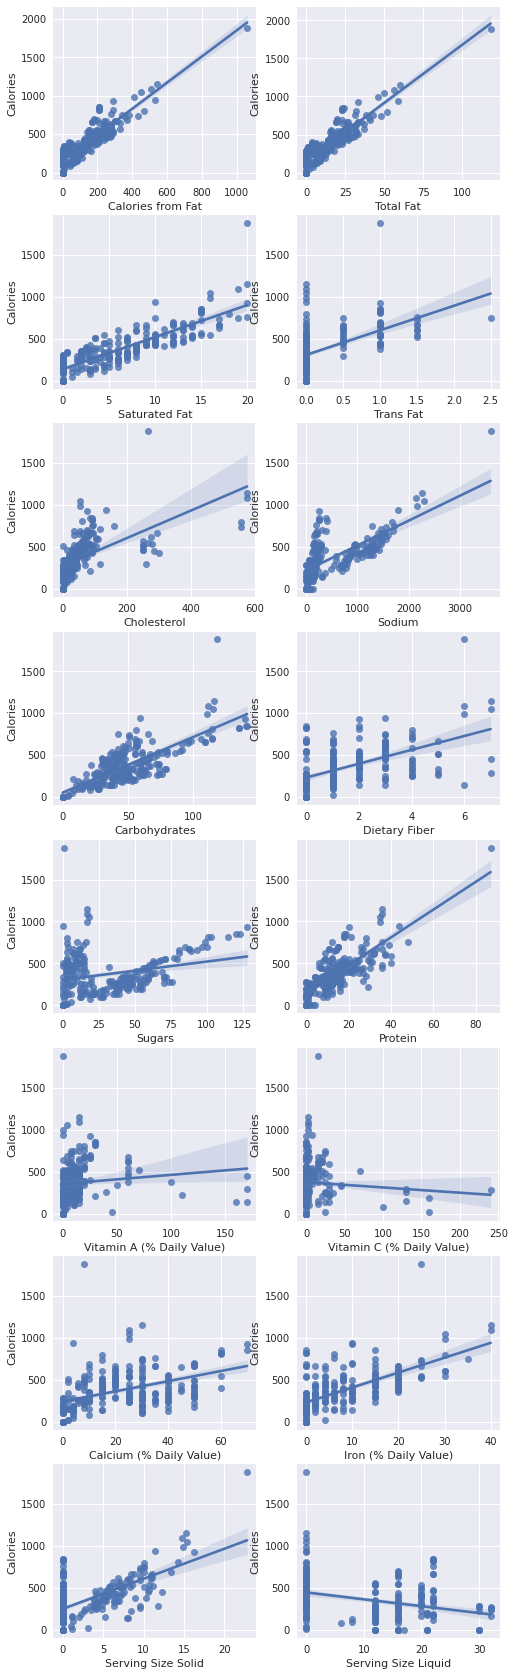

In [197]:
df_numeric_x = df_numeric.drop(columns=["Calories"])
value_y = df_numeric["Calories"]

f, axes = plt.subplots(8, 2, figsize=(8, 30))
for ax, feature in zip(axes.flat, df_numeric_x.columns):
    values = df_numeric_x[feature]
    sns.regplot(x=values, y=value_y, ax=ax)

Se observa que las graficas de Calories from Fat y Total Fat son muy similares. Se analiza si estas dos presentan un relacion lineal

<AxesSubplot:xlabel='Total Fat', ylabel='Calories from Fat'>

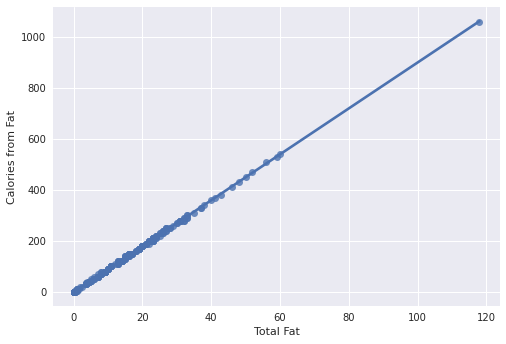

In [198]:
sns.regplot(x=df["Total Fat"], y=df["Calories from Fat"])

<AxesSubplot:>

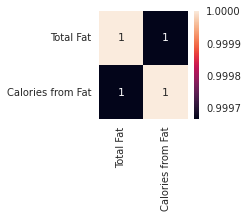

In [199]:
correlation_matrix = df[["Total Fat", "Calories from Fat"]].corr()
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
sns.heatmap(data=correlation_matrix, annot=True, ax=axes)

Efectivamente, la relacion entre Calories from Fat y Total Fat es lineal, por lo tanto se puede descartar una de las dos. En este caso descartamos Calories from Fat.

In [200]:
df_numeric.drop(columns=["Calories from Fat"], inplace=True)

La matriz de correlacion para el resto de datos numericos es la siguiente

<AxesSubplot:>

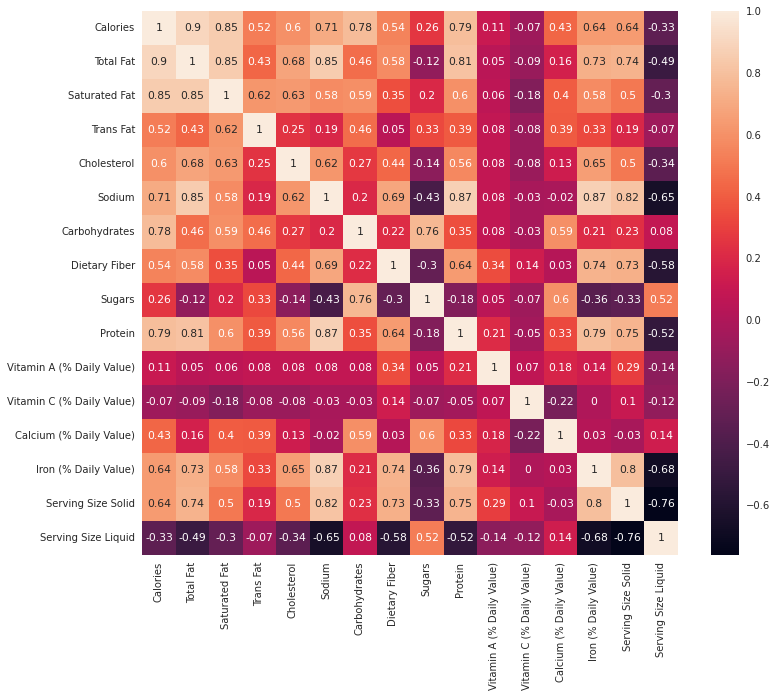

In [201]:
corr_mat_pearson = df_numeric.corr(method="pearson").round(2)
fig, axes = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(data=corr_mat_pearson, annot=True, ax=axes)

Al igual que en las graficas anteriores se ve que hay una fuerte relacion lineal entre las calorias y las grasas, tanto Total Fat como Satured Fat. La relacion tambien es importante con los carbohidratos y las proteinas. Es interesante notar que estos tres (grasas, carbohidratos y proteinas) son los macronutrientes principales.

A continuacion se observa la realacion de las distintas features con Calories, utilizando Informacion Mutua y nuevamente la Correlacion de Pearson

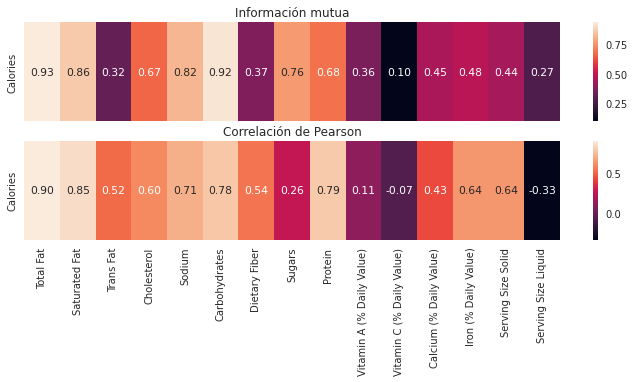

In [202]:
df_numeric_x = df_numeric.drop(columns=["Calories"])

mutual_info = mutual_info_regression(df_numeric_x, value_y)
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
sns.heatmap([mutual_info], ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title("Información mutua")
ax[0].set_xticklabels([])
ax[0].set_yticklabels(["Calories"])

sns.heatmap([corr_mat_pearson.iloc[0][1:]], ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title("Correlación de Pearson")
ax[1].set_xticklabels(df_numeric_x.columns, rotation=90)
ax[1].set_yticklabels(["Calories"])
print()

Como podemos ver la mayoría de features presentan un alto nivel de correlación con la variable a predecir. Las features con menor correlación, y que podrían llegar a eliminarse son Vitamin C (% Daily Value) y Serving size Liquid.

Utilizamos los métodos regresivos de Información Mutua y de F para evaluar las variables más informativas.

array([1159.23919632,  647.19285381,   96.8559961 ,  142.42958151,
        265.73415919,  404.90495557,  105.58830159,   18.64332114,
        422.20683829,    3.09317735,    1.22513816,   58.00190716,
        182.39227962,  182.86522722,   31.39543597])

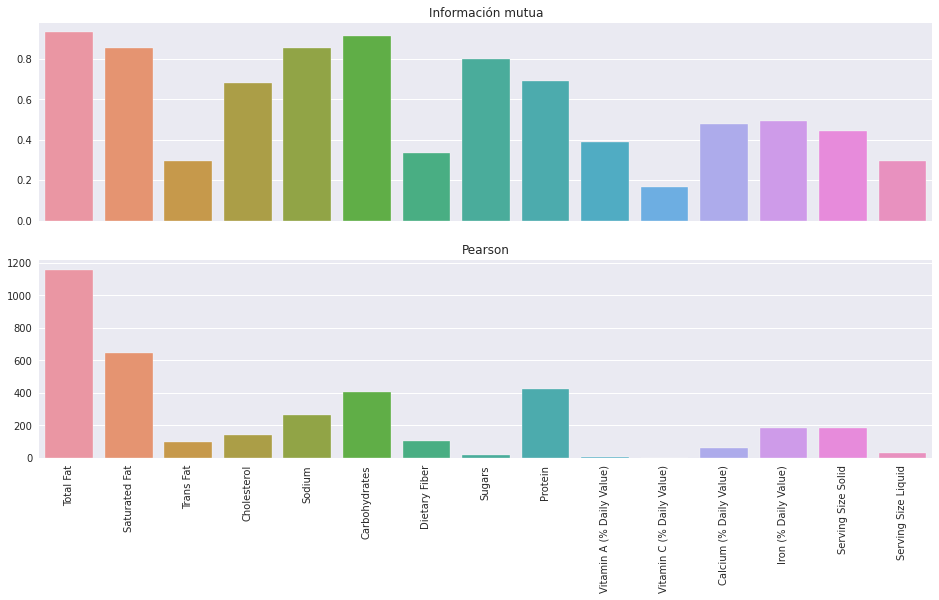

In [203]:
def select_features_mutual_info(X_train, y_train, k="all"):
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs


def select_features_pearson(X_train, y_train, k="all"):
    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs


X_train_mi, mi = select_features_mutual_info(df_numeric_x, value_y)
X_train_pc, pc = select_features_pearson(df_numeric_x, value_y)
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
sns.barplot(x=[c for c in df_numeric_x.columns], y=mi.scores_, ax=axes[0])
axes[0].set_title("Información mutua")
axes[0].set_xticklabels([])
sns.barplot(x=[c for c in df_numeric_x.columns], y=pc.scores_, ax=axes[1])
# Grafico el F score de cada feature
axes[1].set_title("Pearson")
axes[1].set_xticklabels(df_numeric_x.columns, rotation=90)
pc.scores_

In [204]:
df.drop(
    columns=[
        "Trans Fat",
        "Dietary Fiber",
        "Vitamin C (% Daily Value)",
        "Serving Size Liquid",
    ],
    inplace=True,
)
df

,Category,Calories,Calories from Fat,Total Fat,Saturated Fat,Cholesterol,Sodium,Carbohydrates,Sugars,Protein,Vitamin A (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Serving Size Solid,Solid
0,Breakfast,300,120,13.0,5.0,260,750,31,3,17,10,25,15,4.8,1
1,Breakfast,250,70,8.0,3.0,25,770,30,3,18,6,25,8,4.8,1
2,Breakfast,370,200,23.0,8.0,45,780,29,2,14,8,25,10,3.9,1
3,Breakfast,450,250,28.0,10.0,285,860,30,2,21,15,30,15,5.7,1
4,Breakfast,400,210,23.0,8.0,50,880,30,2,21,6,25,10,5.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Smoothies & Shakes,510,150,17.0,9.0,45,280,80,64,12,15,40,8,10.1,1
256,Smoothies & Shakes,690,200,23.0,12.0,55,380,106,85,15,20,50,10,13.4,1
257,Smoothies & Shakes,340,100,11.0,6.0,30,190,53,43,8,10,25,6,6.7,1
258,Smoothies & Shakes,810,290,32.0,15.0,60,400,114,103,21,20,60,6,14.2,1


### Encoding

La unica variable categorica que necesita encoding en este caso es *Category* como las clases son solo 8 podemos hacer one hot encoding.

In [205]:
category_dummies = pd.get_dummies(df["Category"], prefix="Category")
category_dummies

,Category_Beef & Pork,Category_Beverages,Category_Breakfast,Category_Chicken & Fish,Category_Coffee & Tea,Category_Desserts,Category_Salads,Category_Smoothies & Shakes,Category_Snacks & Sides
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
255,0,0,0,0,0,0,0,1,0
256,0,0,0,0,0,0,0,1,0
257,0,0,0,0,0,0,0,1,0
258,0,0,0,0,0,0,0,1,0


Ahora nuestro dataset contiene 27 columnas y 260 filas

Análisis de Variables Numéricas-Categoricas

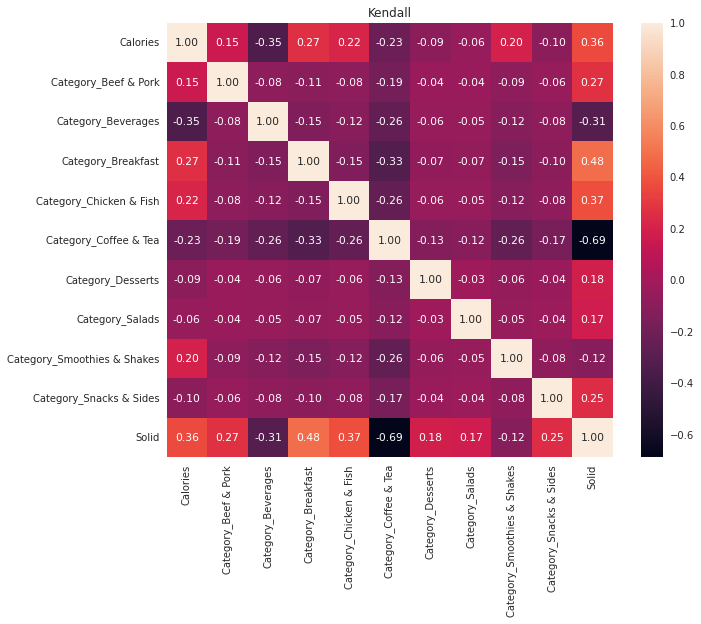

In [206]:
df_categorical = pd.concat([category_dummies, df["Solid"]], axis=1)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

corr_mat_kendall = pd.concat([value_y, df_categorical], axis=1).corr(method="kendall")
axes.set_title("Kendall")
sns.heatmap(corr_mat_kendall, annot=True, fmt=".2f")
sns.set(font_scale=0.9)

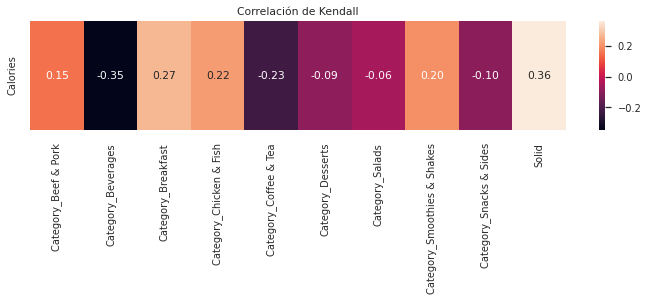

In [207]:
fig, axes = plt.subplots(1, 1, figsize=(12, 2))
sns.heatmap([corr_mat_kendall.iloc[0][1:]], ax=axes, annot=True, fmt=".2f")
axes.set_title("Correlación de Kendall")
categorical_columns = df_categorical.columns
axes.set_xticklabels(categorical_columns, rotation=90)
axes.set_yticklabels(["Calories"])
print()

In [208]:
category_dummies.drop(
    columns=[
        "Category_Beef & Pork",
        "Category_Desserts",
        "Category_Salads",
        "Category_Smoothies & Shakes",
    ],
    inplace=True,
)
category_dummies

,Category_Beverages,Category_Breakfast,Category_Chicken & Fish,Category_Coffee & Tea,Category_Snacks & Sides
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
255,0,0,0,0,0
256,0,0,0,0,0
257,0,0,0,0,0
258,0,0,0,0,0


In [209]:
df.drop(columns=["Category"], inplace=True)
df = pd.concat([df, category_dummies], axis=1)
df

,Calories,Calories from Fat,Total Fat,Saturated Fat,Cholesterol,Sodium,Carbohydrates,Sugars,Protein,Vitamin A (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Serving Size Solid,Solid,Category_Beverages,Category_Breakfast,Category_Chicken & Fish,Category_Coffee & Tea,Category_Snacks & Sides
0,300,120,13.0,5.0,260,750,31,3,17,10,25,15,4.8,1,0,1,0,0,0
1,250,70,8.0,3.0,25,770,30,3,18,6,25,8,4.8,1,0,1,0,0,0
2,370,200,23.0,8.0,45,780,29,2,14,8,25,10,3.9,1,0,1,0,0,0
3,450,250,28.0,10.0,285,860,30,2,21,15,30,15,5.7,1,0,1,0,0,0
4,400,210,23.0,8.0,50,880,30,2,21,6,25,10,5.7,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,510,150,17.0,9.0,45,280,80,64,12,15,40,8,10.1,1,0,0,0,0,0
256,690,200,23.0,12.0,55,380,106,85,15,20,50,10,13.4,1,0,0,0,0,0
257,340,100,11.0,6.0,30,190,53,43,8,10,25,6,6.7,1,0,0,0,0,0
258,810,290,32.0,15.0,60,400,114,103,21,20,60,6,14.2,1,0,0,0,0,0


### Separación en trainning y testing set

In [210]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Calories"]), df["Calories"], test_size=0.2, random_state=42
)

### Normalización

Normalizamos las variables numéricas utilizando el método *'z-score'*. Este método se encuentra implementado en la clase StandarScaler de sklearn.

Hacemos el fit con el set de entrenamiento y luego lo aplicamos al set de prueba.

In [211]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index)
X_train_norm

# Normalización de variables numéricas
# X_train_numeric = X_train.drop(columns=categorical_columns)
# scaler = StandardScaler().fit(X_train_numeric)
# X_train_norm = scaler.transform(X_train_numeric)
# X_train_norm = pd.DataFrame(
#     X_train_norm, columns=X_train_numeric.columns, index=X_train_numeric.index
# )
# X_train_norm = pd.concat([X_train_norm, X_train[categorical_columns]], axis=1)
# X_train_norm

,Calories from Fat,Total Fat,Saturated Fat,Cholesterol,Sodium,Carbohydrates,Sugars,Protein,Vitamin A (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),Serving Size Solid,Solid,Category_Beverages,Category_Breakfast,Category_Chicken & Fish,Category_Coffee & Tea,Category_Snacks & Sides
60,0.398212,0.396063,0.202765,0.533896,1.318220,-0.122942,-0.701885,2.264049,-0.241481,0.502836,1.404949,1.132583,1.080123,-0.361158,-0.426401,2.768875,-0.719895,-0.2
247,0.171596,0.124178,0.763852,0.041312,-0.443096,1.481711,1.606291,-0.135118,0.214102,1.085835,0.028672,-0.774765,-0.925820,-0.361158,-0.426401,-0.361158,-0.719895,-0.2
16,0.398212,0.396063,0.389794,-0.287078,1.196149,-0.225367,-0.905548,0.293305,-0.545203,-0.896360,0.831501,0.374240,1.080123,-0.361158,2.345208,-0.361158,-0.719895,-0.2
55,0.624827,0.599977,0.576823,0.260238,0.934567,-0.430216,-0.803717,0.721727,-0.317412,-0.080162,1.404949,0.512120,1.080123,-0.361158,-0.426401,-0.361158,-0.719895,-0.2
125,-0.961482,-0.963362,-1.106439,-0.615467,-0.774432,-1.625171,-1.007379,-1.077648,-0.545203,-1.246159,-0.888845,-0.774765,-0.925820,2.768875,-0.426401,-0.361158,-0.719895,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0.096057,0.056207,0.202765,-0.232346,1.318220,-0.020518,-0.464279,0.550358,-0.469273,-0.371662,0.258052,0.672981,1.080123,-0.361158,2.345208,-0.361158,-0.719895,-0.2
188,-0.734867,-0.725462,-0.732381,-0.451272,-0.495412,0.286756,0.723753,-0.049433,0.024276,1.085835,-0.659466,-0.774765,-0.925820,-0.361158,-0.426401,-0.361158,1.389092,-0.2
71,0.322673,0.328092,0.202765,0.424433,1.527486,-0.191226,-0.803717,1.921311,1.732713,-0.080162,1.404949,1.684105,1.080123,-0.361158,-0.426401,2.768875,-0.719895,-0.2
106,-0.885944,-0.861405,-0.919410,-0.560735,-0.826749,-1.386180,-0.803717,-1.077648,-0.469273,-1.012960,-0.888845,-0.544964,1.080123,-0.361158,-0.426401,-0.361158,-0.719895,-0.2


In [212]:
X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)

# Normalización de variables numéricas
# X_test_numeric = X_test.drop(columns=categorical_columns)
# X_test_norm = scaler.transform(X_test_numeric)
# X_test_norm = pd.DataFrame(
#     X_test_norm, columns=X_test_numeric.columns, index=X_test_numeric.index
# )
# X_test_norm = pd.concat([X_test_norm, X_test[categorical_columns]], axis=1)

In [213]:
X_test_original = df_original.iloc[X_test.index]
y_formula = (
    X_test_original["Total Fat"] * 9
    + X_test_original["Carbohydrates"] * 4
    + X_test_original["Protein"] * 4
).to_numpy()

reg = LinearRegression().fit(X_train_norm, y_train)

print(f"Train R2 score: {reg.score(X_train_norm, y_train):.5f}")
print(f"Test R2 score: {reg.score(X_test_norm, y_test):.5f}")
print(f"Formula Test R2 score: {r2_score(y_test, y_formula):.5f}")

Train R2 score: 0.99965
Test R2 score: 0.99942
Formula Test R2 score: 0.99920


In [214]:
y_pred = reg.predict(X_test_norm)

for i in range(5):
    print(df_original.iloc[X_test.index[i]]["Item"])
    print(
        f"Calories: {y_test.iloc[i]}, Pred: {y_pred[i]:.3f}, Formula: {y_formula[i]:.3f}"
    )
    print()

Big Breakfast with Egg Whites (Large Biscuit)
Calories: 690, Pred: 694.746, Formula: 693.000

Mocha with Nonfat Milk (Small)
Calories: 270, Pred: 269.888, Formula: 271.500

Frappé Mocha (Small)
Calories: 450, Pred: 445.932, Formula: 450.000

Caramel Mocha (Medium)
Calories: 390, Pred: 390.126, Formula: 394.000

Iced Mocha (Small)
Calories: 290, Pred: 294.952, Formula: 295.000

